In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [116]:
import pickle

In [4]:
# !pip install pyarrow

In [5]:
print(f"pandas version = {pd.__version__}")
print(f"sklearn version = {sklearn.__version__}")

pandas version = 1.4.2
sklearn version = 1.0.2


In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [8]:
df_filter = df.copy()
df_filter = df_filter.sample(n=50000).reset_index(drop=True)

In [9]:
# Duration (Dropoff - Pickup)
df_filter['duration'] = df_filter.tpep_dropoff_datetime -  df_filter.tpep_pickup_datetime
df_filter['duration'] = df_filter.duration.apply(lambda td: td.total_seconds()/ 60)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-06 10:09:53,2024-01-06 10:22:48,1.0,3.16,1.0,N,163,144,2,17.0,0.0,0.5,0.00,0.0,1.0,21.00,2.5,0.00,12.916667
1,2,2024-01-30 15:53:50,2024-01-30 16:50:41,2.0,9.74,1.0,N,231,237,2,-55.5,0.0,-0.5,0.00,0.0,-1.0,-59.50,-2.5,0.00,56.850000
2,1,2024-01-04 14:49:53,2024-01-04 14:54:47,1.0,0.70,1.0,N,236,237,1,6.5,2.5,0.5,2.10,0.0,1.0,12.60,2.5,0.00,4.900000
3,2,2024-01-04 23:44:11,2024-01-04 23:56:03,3.0,1.50,1.0,N,161,186,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.00,11.866667
4,2,2024-01-21 04:13:14,2024-01-21 04:28:33,1.0,5.83,1.0,N,132,216,2,25.4,1.0,0.5,0.00,0.0,1.0,29.65,0.0,1.75,15.316667


# Duration

In [10]:
df_filter.duration.describe()

count    50000.000000
mean        15.580606
std         33.082397
min         -0.500000
25%          7.166667
50%         11.600000
75%         18.666667
max       1438.366667
Name: duration, dtype: float64

In [48]:
df_filter.duration.describe(percentiles=[0.95,0.98,0.99])

count    45429.000000
mean        14.328677
std         10.241773
min          0.033333
50%         11.500000
95%         35.833333
98%         45.531333
99%         51.033333
max         60.000000
Name: duration, dtype: float64

In [49]:
# Filter the DataFrame to include only rows where duration > 0 and duration <= 120 minutes
df_filter = df_filter[(df_filter.duration > 0) & (df_filter.duration <= 120)]

In [38]:
df_filter.duration.max()

60.0

# Passenger Count

In [14]:
df_filter.passenger_count.describe()

count    47581.000000
mean         1.340661
std          0.849637
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: passenger_count, dtype: float64

In [15]:
# Filter the DataFrame to include only rows where passenger_count > 0
df_filter = df_filter[df_filter.passenger_count > 0]

# Fare Amount

In [16]:
df_filter.fare_amount.describe()

count    47063.000000
mean        18.068335
std         18.215164
min       -130.400000
25%          8.600000
50%         12.800000
75%         19.800000
max        389.400000
Name: fare_amount, dtype: float64

In [17]:
# Filter the DataFrame to include only rows where fare_amount > 0
df_filter = df_filter[df_filter.fare_amount > 0]

# trip_distance

In [18]:
df_filter.trip_distance.min()

0.0

In [19]:
df_filter = df_filter[df_filter.trip_distance > 0]

In [20]:
df_filter.trip_distance.min()

0.01

In [39]:
df_filter.reset_index(drop=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-06 10:09:53,2024-01-06 10:22:48,1.0,3.16,1.0,N,163,144,2,17.0,0.0,0.5,0.00,0.00,1.0,21.00,2.5,0.00,12.916667
1,1,2024-01-04 14:49:53,2024-01-04 14:54:47,1.0,0.70,1.0,N,236,237,1,6.5,2.5,0.5,2.10,0.00,1.0,12.60,2.5,0.00,4.900000
2,2,2024-01-04 23:44:11,2024-01-04 23:56:03,3.0,1.50,1.0,N,161,186,1,12.1,1.0,0.5,3.42,0.00,1.0,20.52,2.5,0.00,11.866667
3,2,2024-01-21 04:13:14,2024-01-21 04:28:33,1.0,5.83,1.0,N,132,216,2,25.4,1.0,0.5,0.00,0.00,1.0,29.65,0.0,1.75,15.316667
4,2,2024-01-28 00:26:36,2024-01-28 00:34:20,1.0,1.24,1.0,N,68,249,2,9.3,1.0,0.5,0.00,0.00,1.0,14.30,2.5,0.00,7.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45424,2,2024-01-02 22:03:45,2024-01-02 22:41:40,1.0,7.58,1.0,N,186,188,4,40.1,1.0,0.5,0.00,0.00,1.0,45.10,2.5,0.00,37.916667
45425,1,2024-01-12 11:00:35,2024-01-12 11:08:38,1.0,0.60,1.0,N,263,236,2,7.9,2.5,0.5,0.00,0.00,1.0,11.90,2.5,0.00,8.050000
45426,2,2024-01-06 13:38:24,2024-01-06 13:47:59,1.0,0.85,1.0,N,162,230,2,10.0,0.0,0.5,0.00,0.00,1.0,14.00,2.5,0.00,9.583333
45427,2,2024-01-07 06:25:19,2024-01-07 07:00:25,1.0,17.35,2.0,N,229,132,2,70.0,0.0,0.5,0.00,6.94,1.0,80.94,2.5,0.00,35.100000


In [40]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45429 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               45429 non-null  int32         
 1   tpep_pickup_datetime   45429 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  45429 non-null  datetime64[ns]
 3   passenger_count        45429 non-null  float64       
 4   trip_distance          45429 non-null  float64       
 5   RatecodeID             45429 non-null  float64       
 6   store_and_fwd_flag     45429 non-null  object        
 7   PULocationID           45429 non-null  object        
 8   DOLocationID           45429 non-null  object        
 9   payment_type           45429 non-null  int64         
 10  fare_amount            45429 non-null  float64       
 11  extra                  45429 non-null  float64       
 12  mta_tax                45429 non-null  float64       
 13  t

# Feature Selection

In [23]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [24]:
df_filter[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [25]:
df_filter[categorical] = df_filter[categorical].astype(str)

In [26]:
df_filter[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [57]:
train_dicts = df_filter[categorical + numerical].to_dict(orient='records')

In [58]:
train_dicts

[{'PULocationID': '163', 'DOLocationID': '144', 'trip_distance': 3.16},
 {'PULocationID': '236', 'DOLocationID': '237', 'trip_distance': 0.7},
 {'PULocationID': '161', 'DOLocationID': '186', 'trip_distance': 1.5},
 {'PULocationID': '132', 'DOLocationID': '216', 'trip_distance': 5.83},
 {'PULocationID': '68', 'DOLocationID': '249', 'trip_distance': 1.24},
 {'PULocationID': '142', 'DOLocationID': '48', 'trip_distance': 0.78},
 {'PULocationID': '140', 'DOLocationID': '140', 'trip_distance': 0.5},
 {'PULocationID': '132', 'DOLocationID': '265', 'trip_distance': 26.19},
 {'PULocationID': '237', 'DOLocationID': '166', 'trip_distance': 3.49},
 {'PULocationID': '141', 'DOLocationID': '234', 'trip_distance': 3.16},
 {'PULocationID': '148', 'DOLocationID': '79', 'trip_distance': 1.68},
 {'PULocationID': '161', 'DOLocationID': '48', 'trip_distance': 1.1},
 {'PULocationID': '238', 'DOLocationID': '239', 'trip_distance': 0.83},
 {'PULocationID': '238', 'DOLocationID': '238', 'trip_distance': 0.68},

In [59]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [60]:
X_train

<45429x433 sparse matrix of type '<class 'numpy.float64'>'
	with 136287 stored elements in Compressed Sparse Row format>

In [61]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=11',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',
 'DOLocationID=149',

In [63]:
target = 'duration'
y_train =df_filter[target].values

In [64]:
y_train

array([12.91666667,  4.9       , 11.86666667, ...,  9.58333333,
       35.1       ,  3.58333333])

In [65]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [66]:
y_pred = lr.predict(X_train)

# Evaluation

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


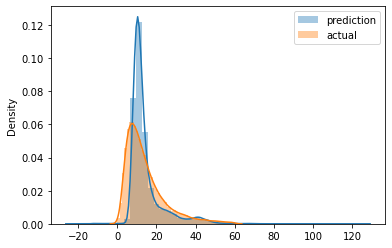

In [67]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [68]:
y_pred

array([17.35163581,  8.18426094, 12.66630952, ..., 11.69879108,
       45.39811791,  8.26910772])

In [75]:
y_pred.max()

126.12698375454796

In [69]:
# Creating a new DataFrame df_predict
df_predict = pd.DataFrame()
df_predict['duration'] = df_filter.duration
df_predict['duration_prediction'] = y_pred

In [70]:
df_predict

,duration,duration_prediction
0,12.916667,17.351636
2,4.900000,8.184261
3,11.866667,12.666310
4,15.316667,13.023855
5,7.733333,11.587322
...,...,...
49995,37.916667,40.391136
49996,8.050000,6.479927
49997,9.583333,11.698791
49998,35.100000,45.398118


In [81]:
df_predict[df_predict['duration_prediction'] >= 100 ]

,duration,duration_prediction
7937,55.85,126.126984
13456,46.25,105.577182


In [84]:
mean_squared_error(y_train,y_pred,squared = False)

5.693621815065987

In [90]:
def read_df(filename):
    df = pd.read_parquet(filename)
    
    df_filter = df.copy()
    df_filter = df_filter.sample(n=50000).reset_index(drop=True)
    
    df_filter['duration'] = df_filter.tpep_dropoff_datetime -  df_filter.tpep_pickup_datetime
    df_filter['duration'] = df_filter.duration.apply(lambda td: td.total_seconds()/ 60)

    df_filter = df_filter[(df_filter.duration > 0) & (df_filter.duration <= 120)]
    df_filter = df_filter[df_filter.passenger_count > 0]
    df_filter = df_filter[df_filter.fare_amount > 0]
    df_filter = df_filter[df_filter.trip_distance > 0]
    
    df_filter.reset_index(drop=True)
    
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    
    df_filter[categorical] = df_filter[categorical].astype(str)
    
    return df_filter
    

In [91]:
df_train = read_df('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df_val = read_df('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [92]:
len(df_train), len(df_val)

(45820, 45850)

In [93]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [100]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [95]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [112]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.433419705227153

In [113]:
print(f"MAPE ={mean_absolute_percentage_error(y_val, y_pred)}")

MAPE =0.4399328529717037


In [114]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.37519741989096

In [115]:
print(f"MAPE ={mean_absolute_percentage_error(y_val, y_pred)}")

MAPE =0.7181431796357006


In [117]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)